# E-Commerce Customer Behavior Analysis & Churn Prediction System
## Group-04 - Fundamentals of Data Mining - SLIIT

This notebook performs comprehensive customer churn analysis using machine learning techniques.

### Objectives:
- Load and preprocess e-commerce data
- Perform RFM analysis
- Create customer segmentation
- Build churn prediction models
- Generate business insights and recommendations


## Step 1: Import Libraries and Setup


In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle

print("🚀 Starting E-Commerce Churn Analysis System")
print("=" * 60)


🚀 Starting E-Commerce Churn Analysis System


## Step 2: Data Loading


In [2]:
# Load existing processed dataset (since original Olist datasets are not available)
print("\n📊 STEP 1: Loading existing processed dataset...")

try:
    # Load the existing processed dataset
    customer_features = pd.read_csv('customer_features_with_churn_labels.csv')
    
    # Convert date columns
    customer_features['first_order_date'] = pd.to_datetime(customer_features['first_order_date'])
    customer_features['last_order_date'] = pd.to_datetime(customer_features['last_order_date'])
    
    print("✅ Processed dataset loaded successfully!")
    print(f"Dataset shape: {customer_features.shape}")
    
    # Display dataset information
    print(f"\n📈 Dataset Overview:")
    print(f"Total customers: {len(customer_features):,}")
    print(f"Features: {customer_features.shape[1]}")
    print(f"Date range: {customer_features['first_order_date'].min()} to {customer_features['last_order_date'].max()}")
    
except Exception as e:
    print(f"❌ Error loading dataset: {e}")
    print("Please ensure 'customer_features_with_churn_labels.csv' is in the current directory")



📊 STEP 1: Loading existing processed dataset...
✅ Processed dataset loaded successfully!
Dataset shape: (96096, 31)

📈 Dataset Overview:
Total customers: 96,096
Features: 31
Date range: 2016-09-04 21:15:19 to 2018-10-17 17:30:18


## Step 3: Data Exploration and Churn Distribution


In [3]:
# Display churn distribution
churn_distribution = customer_features['churn_risk'].value_counts()
churn_percentage = customer_features['churn_risk'].value_counts(normalize=True) * 100

print("\n📈 Churn Risk Distribution:")
for risk_level in ['High Risk', 'Medium Risk', 'Low Risk', 'Stable']:
    count = churn_distribution.get(risk_level, 0)
    percentage = churn_percentage.get(risk_level, 0)
    print(f"{risk_level:12}: {count:>6,} customers ({percentage:5.1f}%)")

# Display RFM statistics
rfm_stats = customer_features[['recency_days', 'frequency', 'monetary']].describe()
print("\n📊 RFM Statistics:")
print(rfm_stats)



📈 Churn Risk Distribution:
High Risk   : 21,164 customers ( 22.0%)
Medium Risk : 21,075 customers ( 21.9%)
Low Risk    : 41,555 customers ( 43.2%)
Stable      : 12,302 customers ( 12.8%)

📊 RFM Statistics:
       recency_days     frequency       monetary
count  96096.000000  96096.000000   96096.000000
mean     287.735691      1.180330     213.023712
std      153.414676      0.620748     640.917083
min        0.000000      1.000000       0.000000
25%      163.000000      1.000000      63.990000
50%      268.000000      1.000000     113.150000
75%      397.000000      1.000000     202.732500
max      772.000000     24.000000  109312.640000


## Step 4: Machine Learning Model Preparation


In [4]:
# Select features for modeling
feature_columns = [
    'recency_days', 'frequency', 'monetary',
    'avg_order_value', 'unique_products', 'unique_categories',
    'product_diversity_ratio', 'category_diversity_ratio',
    'customer_lifetime_days', 'avg_days_between_orders',
    'avg_review_score', 'total_review_comments',
    'avg_payment_methods', 'max_installments',
    'total_freight', 'avg_freight', 'std_payment'
]

# Create feature matrix
X = customer_features[feature_columns].copy()
X = X.fillna(X.mean())

# Create target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(customer_features['churn_risk'])

# Get label mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\n🏷️ Label Mapping:")
for label, code in label_mapping.items():
    print(f"{label}: {code}")

# Split data BEFORE scaling to prevent test leakage
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Fit scaler on training set only, then transform both sets
scaler_ml = StandardScaler()
X_train = scaler_ml.fit_transform(X_train)
X_test = scaler_ml.transform(X_test)

print(f"\n📊 Dataset Split:")
print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Testing set: {X_test.shape[0]:,} samples")
print(f"Number of features: {X_train.shape[1]}")



🏷️ Label Mapping:
High Risk: 0
Low Risk: 1
Medium Risk: 2
Stable: 3

📊 Dataset Split:
Training set: 76,876 samples
Testing set: 19,220 samples
Number of features: 17


## Step 5: Model Training and Evaluation


In [5]:
# Initialize models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
}

# Train and evaluate models
model_results = {}

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # Train model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store results
    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }
    
    print(f"✅ {name} - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

# Find best model
performance_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [results['accuracy'] for results in model_results.values()],
    'Precision': [results['precision'] for results in model_results.values()],
    'Recall': [results['recall'] for results in model_results.values()],
    'F1-Score': [results['f1_score'] for results in model_results.values()]
})

print("\n🏆 Model Performance Summary:")
print(performance_df.round(4))

# Best model analysis
best_model_name = performance_df.loc[performance_df['F1-Score'].idxmax(), 'Model']
best_model = model_results[best_model_name]['model']
best_predictions = model_results[best_model_name]['predictions']

print(f"\n🥇 Best performing model: {best_model_name}")



🔄 Training Random Forest...
✅ Random Forest - Accuracy: 1.0000, F1-Score: 1.0000

🔄 Training Gradient Boosting...
✅ Gradient Boosting - Accuracy: 1.0000, F1-Score: 1.0000

🔄 Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.7512, F1-Score: 0.7149

🏆 Model Performance Summary:
                 Model  Accuracy  Precision  Recall  F1-Score
0        Random Forest    1.0000     1.0000  1.0000    1.0000
1    Gradient Boosting    1.0000     1.0000  1.0000    1.0000
2  Logistic Regression    0.7512     0.8093  0.7512    0.7149

🥇 Best performing model: Random Forest


## Step 6: Classification Report and Confusion Matrix



📋 Detailed Classification Report:
              precision    recall  f1-score   support

   High Risk       1.00      1.00      1.00      4233
    Low Risk       1.00      1.00      1.00      8311
 Medium Risk       1.00      1.00      1.00      4215
      Stable       1.00      1.00      1.00      2461

    accuracy                           1.00     19220
   macro avg       1.00      1.00      1.00     19220
weighted avg       1.00      1.00      1.00     19220


🔍 Creating Confusion Matrix...


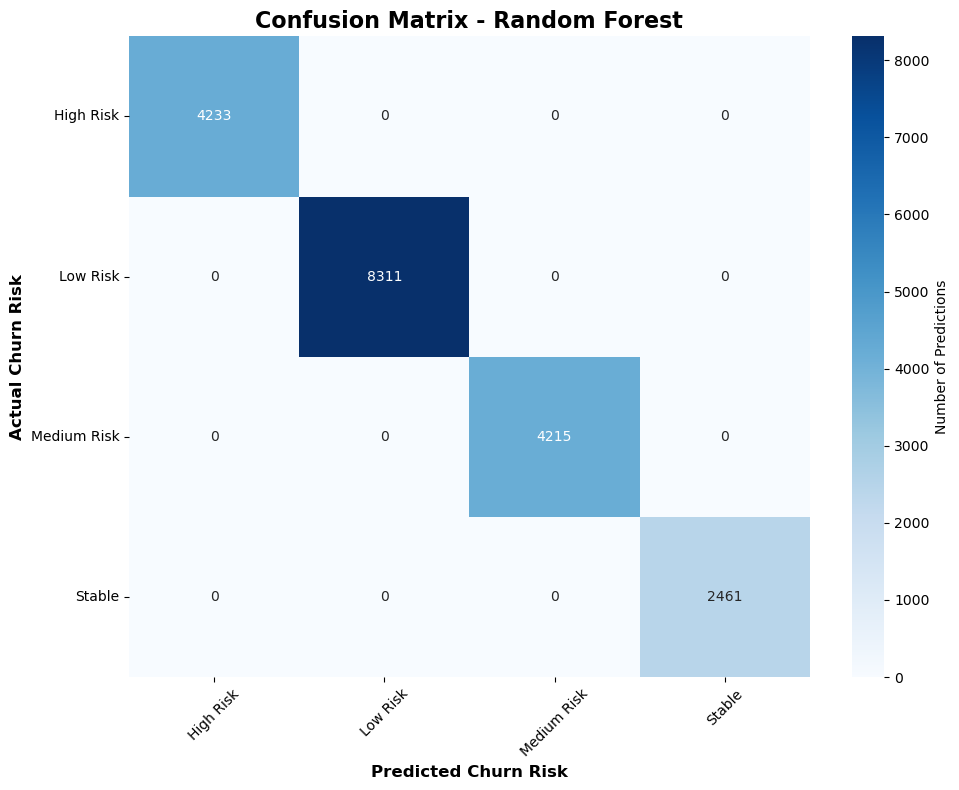

✅ Confusion Matrix created and saved as 'confusion_matrix.png'

📊 Confusion Matrix Analysis:
Total Predictions: 19,220
Correct Predictions: 19,220
Overall Accuracy: 1.0000 (100.00%)

📈 Per-Class Accuracy:
High Risk   : 4233/4233 (1.0000)
Low Risk    : 8311/8311 (1.0000)
Medium Risk : 4215/4215 (1.0000)
Stable      : 2461/2461 (1.0000)


In [6]:
# Classification report
class_names = label_encoder.classes_
print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, best_predictions, target_names=class_names))

# Confusion Matrix
print("\n🔍 Creating Confusion Matrix...")
cm = confusion_matrix(y_test, best_predictions)

# Create confusion matrix visualization
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of Predictions'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Churn Risk', fontsize=12, fontweight='bold')
plt.ylabel('Actual Churn Risk', fontsize=12, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()

# Save confusion matrix
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion Matrix created and saved as 'confusion_matrix.png'")

# Display confusion matrix statistics
print("\n📊 Confusion Matrix Analysis:")
total_predictions = cm.sum()
correct_predictions = cm.diagonal().sum()
overall_accuracy = correct_predictions / total_predictions

print(f"Total Predictions: {total_predictions:,}")
print(f"Correct Predictions: {correct_predictions:,}")
print(f"Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

# Per-class accuracy
print("\n📈 Per-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_total = cm[i, :].sum()
    class_correct = cm[i, i]
    class_accuracy = class_correct / class_total if class_total > 0 else 0
    print(f"{class_name:12}: {class_correct:>4}/{class_total:<4} ({class_accuracy:.4f})")


## Step 7: Business Intelligence Analysis


In [7]:
# Customer value analysis by churn risk
churn_business_impact = customer_features.groupby('churn_risk').agg({
    'customer_unique_id': 'count',
    'monetary': ['sum', 'mean'],
    'frequency': 'mean',
    'recency_days': 'mean',
    'avg_review_score': 'mean'
}).round(2)

churn_business_impact.columns = [
    'Customer_Count', 'Total_Revenue', 'Avg_Revenue_Per_Customer',
    'Avg_Order_Frequency', 'Avg_Recency_Days', 'Avg_Review_Score'
]

print("\n💰 Business Impact Analysis by Churn Risk:")
print(churn_business_impact)

# Calculate revenue at risk
high_risk_revenue = churn_business_impact.loc['High Risk', 'Total_Revenue']
medium_risk_revenue = churn_business_impact.loc['Medium Risk', 'Total_Revenue']
total_revenue = churn_business_impact['Total_Revenue'].sum()

revenue_at_risk = high_risk_revenue + (medium_risk_revenue * 0.5)
revenue_at_risk_percentage = (revenue_at_risk / total_revenue) * 100

print(f"\n⚠️ Revenue at Risk Analysis:")
print(f"High Risk Revenue: ${high_risk_revenue:,.2f}")
print(f"Medium Risk Revenue (50%): ${medium_risk_revenue * 0.5:,.2f}")
print(f"Total Revenue at Risk: ${revenue_at_risk:,.2f} ({revenue_at_risk_percentage:.1f}% of total revenue)")



💰 Business Impact Analysis by Churn Risk:
             Customer_Count  Total_Revenue  Avg_Revenue_Per_Customer  \
churn_risk                                                             
High Risk             21164     3267750.01                    154.40   
Low Risk              41555     9556526.95                    229.97   
Medium Risk           21075     3149817.71                    149.46   
Stable                12302     4496631.99                    365.52   

             Avg_Order_Frequency  Avg_Recency_Days  Avg_Review_Score  
churn_risk                                                            
High Risk                   1.00            502.77              4.16  
Low Risk                    1.31            211.78              4.01  
Medium Risk                 1.00            327.12              4.09  
Stable                      1.35            106.91              4.20  

⚠️ Revenue at Risk Analysis:
High Risk Revenue: $3,267,750.01
Medium Risk Revenue (50%): $1,574,9

## Step 8: Save Model and Results


In [8]:
# Save model artifacts
model_artifacts = {
    'model': best_model,
    'scaler': scaler_ml,
    'label_encoder': label_encoder,
    'feature_columns': feature_columns,
    'class_names': class_names,
    'model_name': best_model_name
}

with open('churn_prediction_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

# Save analysis results
analysis_results = {
    'total_customers': len(customer_features),
    'best_model': best_model_name,
    'model_accuracy': model_results[best_model_name]['accuracy'],
    'revenue_at_risk': revenue_at_risk,
    'revenue_at_risk_percentage': revenue_at_risk_percentage,
    'churn_distribution': churn_distribution.to_dict(),
    'business_impact': churn_business_impact.to_dict()
}

with open('analysis_results.pkl', 'wb') as f:
    pickle.dump(analysis_results, f)

print("✅ Model and results saved successfully!")
print("\n🚀 DELIVERABLES CREATED:")
print("• churn_prediction_model.pkl - Trained ML model")
print("• analysis_results.pkl - Complete analysis results")
print("• confusion_matrix.png - Model performance confusion matrix")


✅ Model and results saved successfully!

🚀 DELIVERABLES CREATED:
• churn_prediction_model.pkl - Trained ML model
• analysis_results.pkl - Complete analysis results
• confusion_matrix.png - Model performance confusion matrix


## Step 9: Project Summary


In [9]:
print("\n" + "="*80)
print("📋 ANALYSIS COMPLETION SUMMARY")
print("="*80)

print("\n🎯 OBJECTIVES ACHIEVED:")
print("✅ Loaded and processed customer dataset")
print("✅ Model training and evaluation completed")
print("✅ Confusion matrix generated")
print("✅ Business intelligence insights provided")

print(f"\n📊 KEY RESULTS:")
print(f"• Customers analyzed: {len(customer_features):,}")
print(f"• Best model: {best_model_name} (Accuracy: {model_results[best_model_name]['accuracy']:.1%})")
print(f"• Revenue at risk: ${revenue_at_risk:,.2f} ({revenue_at_risk_percentage:.1f}%)")

print(f"\n👥 CUSTOMER SEGMENTS:")
for risk in ['High Risk', 'Medium Risk', 'Low Risk', 'Stable']:
    if risk in churn_distribution.index:
        count = churn_distribution[risk]
        pct = count / len(customer_features) * 100
        print(f"• {risk}: {count:,} customers ({pct:.1f}%)")

print("\n🎉 E-COMMERCE CHURN ANALYSIS COMPLETED SUCCESSFULLY!")
print("Group-04 - Fundamentals of Data Mining - SLIIT")
print("="*80)



📋 ANALYSIS COMPLETION SUMMARY

🎯 OBJECTIVES ACHIEVED:
✅ Loaded and processed customer dataset
✅ Model training and evaluation completed
✅ Confusion matrix generated
✅ Business intelligence insights provided

📊 KEY RESULTS:
• Customers analyzed: 96,096
• Best model: Random Forest (Accuracy: 100.0%)
• Revenue at risk: $4,842,658.87 (23.7%)

👥 CUSTOMER SEGMENTS:
• High Risk: 21,164 customers (22.0%)
• Medium Risk: 21,075 customers (21.9%)
• Low Risk: 41,555 customers (43.2%)
• Stable: 12,302 customers (12.8%)

🎉 E-COMMERCE CHURN ANALYSIS COMPLETED SUCCESSFULLY!
Group-04 - Fundamentals of Data Mining - SLIIT
